In [66]:
import pandas as pd
import os
import base64
import time
import pickle as p
import numpy as np
import matplotlib.pyplot as plt
import pandas.core.algorithms as algos
from sklearn.model_selection import train_test_split
from sklearn import metrics
from functools import reduce
import datetime
import logging
import matplotlib.style as style
import matplotlib
import matplotlib.lines as mlines
from matplotlib.ticker import FuncFormatter
style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

In [67]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [68]:
import gc
gc.collect()

169

### Data Loading and Preprocessing

In [69]:
Client = pd.read_excel('../data/Client_info_20191118.xlsx',sheet_name='Sheet1')
TPA = pd.read_excel('../data/Copy_of_TPA_cash.xlsx',sheet_name='Sheet1')
Client = Client.merge(TPA,how='left',left_on='Client ID',right_on='HOST ID')
Customer = pd.read_csv('../data/Customer_Data_Request_20191121.csv')

In [70]:
Client_cols = ['Active',
 'Client ID',
 'Account Name',
 'Industry',
 'NAICS Code',
 'NAICS Description',
 'Broker',
 'TPA_x',
 'Launch Date',
 'Termination Date',
 'Affiliate/Fed Gov?',
 'Cash']

In [71]:
Customer = Customer.merge(Client[Client_cols],how='left',left_on='Unique_Company_ID',right_on='Client ID')

In [72]:
Client['Affiliate/Fed Gov?'].value_counts(dropna = False)

Affiliate    497
Fed Gov       12
NaN            5
Name: Affiliate/Fed Gov?, dtype: int64

In [73]:
Perf = pd.read_csv('../data/Performance_Data_Request_20191204.csv')
Perf = Perf.merge(Customer, how='left',on='Unique_Customer_ID')
Perf['Year_and_Month'] = pd.to_datetime(Perf['Year_and_Month'].astype(str), format = '%Y%m')
Perf['YQ'] = pd.PeriodIndex(Perf['Year_and_Month'], freq='Q')
# Perf.to_csv('./data/Perf.csv',index = False)

In [74]:
Perf.loc[Perf['Order_Amount']=='.','Order_Amount']=0
Perf['Order_Amount'] = Perf['Order_Amount'].astype(float)

In [75]:
# Assign Payment Order as a new column
Perf['Payment_Order'] = Perf.groupby('Unique_Order_ID')['Year_and_Month'].rank(method='first')

In [76]:
Perf['Year'] = Perf['YQ'].dt.year

In [77]:
Perf['Bad']=0
Perf.loc[Perf['Default_Status'].isin(['151+','Chargeoff']),'Bad']=1
Perf['Ever_Bad'] = Perf.groupby('Unique_Order_ID')['Bad'].transform(pd.Series.cumsum)

In [119]:
Perf.shape

(38397651, 53)

In [9]:
Perf.head()

,Unique_Order_ID,Unique_Customer_ID,Order_Amount,Product_Markup,Payments_Due,Current_Balance,Date_account_went_delinquent,Default_Status,Delinquency_Bucket,Losses,Auto_Pay_Enrollment,Order_Closed_Flag,Type_of_Backup_Payment,Spending_Limit_at_time_of_Order,Tenure_at_time_of_Order,Salary_at_time_of_Order,Street1_x,Street2_x,City_x,State_x,Zip_x,items_ordered,Year_and_Month,EMPSTATUS,Order_Date,Unique_Company_ID,Enrollment_Date,Assigned_Spending_Limit,Customer_Tenure,Customer_Salary,Prior_Customer_Flag,Street1_y,Street2_y,City_y,State_y,Zip_y,Status,Term_Date,Active,Client ID,Account Name,Industry,NAICS Code,NAICS Description,Broker,TPA_x,Launch Date,Termination Date,Affiliate/Fed Gov?,Cash,YQ
0,10000091,100486182,1072.88,.,40.11,907.86,.,Current,000-000,0.0,PA,N,ACH,96.6,327,800.29,929 IMPERIAL CT,NaN,HALETHORPE,MD,21227.0,DeWalt 12in 15-Amp Double-Bevel Compound Miter...,2014-04-01,Employed,03/15/2014,2049.0,02/25/2014,9660.0,327.0,80029.0,Repeat Buyer,929 IMPERIAL CT,NaN,HALETHORPE,MD,21227,Employed,NaN,Y,2049.0,FEDERAL GOVERNMENT/POSTAL WORKERS/NIH/DEPT OF ...,Federal Government/Associations,NaN,NaN,NaN,NaN,2002-07-01,NaT,Fed Gov,NaN,2014Q2
1,10000091,100486182,1072.88,.,40.11,817.86,.,Current,000-000,0.0,PA,N,ACH,96.6,327,800.29,929 IMPERIAL CT,NaN,HALETHORPE,MD,21227.0,DeWalt 12in 15-Amp Double-Bevel Compound Miter...,2014-05-01,Employed,03/15/2014,2049.0,02/25/2014,9660.0,327.0,80029.0,Repeat Buyer,929 IMPERIAL CT,NaN,HALETHORPE,MD,21227,Employed,NaN,Y,2049.0,FEDERAL GOVERNMENT/POSTAL WORKERS/NIH/DEPT OF ...,Federal Government/Associations,NaN,NaN,NaN,NaN,2002-07-01,NaT,Fed Gov,NaN,2014Q2
2,10000091,100486182,1072.88,.,40.11,727.86,.,Current,000-000,0.0,PA,N,ACH,96.6,327,800.29,929 IMPERIAL CT,NaN,HALETHORPE,MD,21227.0,DeWalt 12in 15-Amp Double-Bevel Compound Miter...,2014-06-01,Employed,03/15/2014,2049.0,02/25/2014,9660.0,327.0,80029.0,Repeat Buyer,929 IMPERIAL CT,NaN,HALETHORPE,MD,21227,Employed,NaN,Y,2049.0,FEDERAL GOVERNMENT/POSTAL WORKERS/NIH/DEPT OF ...,Federal Government/Associations,NaN,NaN,NaN,NaN,2002-07-01,NaT,Fed Gov,NaN,2014Q2
3,10000091,100486182,1072.88,.,40.11,637.86,.,Current,000-000,0.0,PA,N,ACH,96.6,327,800.29,929 IMPERIAL CT,NaN,HALETHORPE,MD,21227.0,DeWalt 12in 15-Amp Double-Bevel Compound Miter...,2014-07-01,Employed,03/15/2014,2049.0,02/25/2014,9660.0,327.0,80029.0,Repeat Buyer,929 IMPERIAL CT,NaN,HALETHORPE,MD,21227,Employed,NaN,Y,2049.0,FEDERAL GOVERNMENT/POSTAL WORKERS/NIH/DEPT OF ...,Federal Government/Associations,NaN,NaN,NaN,NaN,2002-07-01,NaT,Fed Gov,NaN,2014Q3
4,10000091,100486182,1072.88,.,40.11,547.86,.,Current,000-000,0.0,PA,N,ACH,96.6,327,800.29,929 IMPERIAL CT,NaN,HALETHORPE,MD,21227.0,DeWalt 12in 15-Amp Double-Bevel Compound Miter...,2014-08-01,Employed,03/15/2014,2049.0,02/25/2014,9660.0,327.0,80029.0,Repeat Buyer,929 IMPERIAL CT,NaN,HALETHORPE,MD,21227,Employed,NaN,Y,2049.0,FEDERAL GOVERNMENT/POSTAL WORKERS/NIH/DEPT OF ...,Federal Government/Associations,NaN,NaN,NaN,NaN,2002-07-01,NaT,Fed Gov,NaN,2014Q3


In [16]:
Perf.loc[Perf['Payments_Due']=='.','Payments_Due']=0
Perf.loc[Perf['Spending_Limit_at_time_of_Order']=='.','Spending_Limit_at_time_of_Order']=0

In [18]:
Perf['limit_flag'] = Perf['Payments_Due'].astype(float) > Perf['Spending_Limit_at_time_of_Order'].astype(float)
Perf[(Perf['Default_Status']=='Chargeoff')&(Perf['limit_flag']==1)]['Unique_Order_ID'].nunique()/Perf[Perf['limit_flag']==1]['Unique_Order_ID'].nunique()

0.11459296237671983

In [24]:
# Perf[Perf['Product_Markup']=='.'].groupby('YQ').agg({'Unique_Order_ID':'nunique'})['Unique_Order_ID']/Perf.groupby('YQ').agg({'Unique_Order_ID':'nunique'})['Unique_Order_ID']

YQ
2012Q1    1.000000
2012Q2    1.000000
2012Q3    1.000000
2012Q4    1.000000
2013Q1    1.000000
2013Q2    1.000000
2013Q3    1.000000
2013Q4    1.000000
2014Q1    1.000000
2014Q2    1.000000
2014Q3    1.000000
2014Q4    1.000000
2015Q1    0.860639
2015Q2    0.690262
2015Q3    0.506244
2015Q4    0.282418
2016Q1    0.097662
2016Q2    0.049045
2016Q3    0.027895
2016Q4    0.022884
2017Q1    0.024241
2017Q2    0.025730
2017Q3    0.028687
2017Q4    0.028511
2018Q1    0.032138
2018Q2    0.030053
2018Q3    0.028613
2018Q4    0.025568
2019Q1    0.162823
2019Q2    0.327331
2019Q3    0.502154
2019Q4    0.609801
Freq: Q-DEC, Name: Unique_Order_ID, dtype: float64

### Create C/O Flag by criteria --- 150 DPD/No Pay last 90 

In [12]:
Perf['Balance_diff_past_90'] = Perf['Current_Balance'].diff(-3)
# Filter where the difference is calculated between different orders, and then assign NaN to the value
mask = Perf['Unique_Order_ID']!= Perf['Unique_Order_ID'].shift(3)
Perf['Balance_diff_past_90'][mask]=np.nan

In [10]:
# Perf[['Unique_Order_ID','Current_Balance','Balance_diff_past_90']].head(50)

In [11]:
# def CO_Flag(row):
#     if (row['Delinquency_Bucket']=='151+') and (row['Balance_diff_past_90']==0):
#         return 1
#     else:
#         return 0

In [9]:
Perf_af15 = Perf.groupby('Unique_Order_ID').filter(lambda x: x['Year_and_Month'].min()>=pd.to_datetime('2015-01'))

In [10]:
Perf_af15.shape

(28922383, 51)

In [15]:
Perf['CO_Flag'] = 0
Perf.loc[(Perf['Delinquency_Bucket']=='151+') & (Perf['Balance_diff_past_90']==0),'CO_Flag']=1

In [18]:
# def new_DQ(row):
#     if row['CO_Flag'] ==1 :
#         return 'CO'
#     else:
#         return row['Delinquency_Bucket']

In [19]:
# Perf['CO_Flag'] = Perf.apply(CO_Flag,axis=1)
# Perf['DQ_new']  = Perf.apply(new_DQ,axis = 1)

In [16]:
Perf['DQ_new'] = Perf['Delinquency_Bucket']
Perf.loc[Perf['CO_Flag']==1,'DQ_new'] = 'CO'

In [17]:
Perf.groupby(['Default_Status','CO_Flag']).size()

Default_Status  CO_Flag
001-030         0           2977970
031-060         0            823220
061-090         0            586676
091-120         0            483602
121-150         0            427299
151+            0           1115044
                1            326051
Bankruptcy      0            165796
                1             41306
Chargeoff       0            351118
                1               682
Current         0          30940967
Fraud           0            156978
                1               942
dtype: int64

In [20]:
Perf.groupby('YQ').agg({'CO_Flag':'sum','Unique_Order_ID':'count'}).reset_index()

,YQ,CO_Flag,Unique_Order_ID
0,2012Q1,0,50256
1,2012Q2,0,143959
2,2012Q3,118,256584
3,2012Q4,1543,431733
4,2013Q1,1994,605728
5,2013Q2,2100,655469
6,2013Q3,2808,694354
7,2013Q4,3618,764010
8,2014Q1,4794,788795
9,2014Q2,5735,788875


In [19]:
CO_Loss = Perf[Perf['Default_Status']=='Chargeoff'].groupby(['YQ']).agg({'Losses':'sum'}).reset_index()
Total_Balance = Perf.groupby(['YQ']).agg({'Current_Balance':'sum'}).reset_index()
CO_Loss.merge(Total_Balance, how='left', on= 'YQ')

,YQ,Losses,Current_Balance
0,2012Q2,970.06,1.536808e+08
1,2012Q3,191187.73,2.389975e+08
2,2012Q4,493415.99,3.617630e+08
3,2013Q1,536864.12,4.423111e+08
4,2013Q2,2428065.53,4.123733e+08
5,2013Q3,2611896.68,3.902052e+08
6,2013Q4,3971190.71,4.451606e+08
7,2014Q1,3655656.25,4.967926e+08
8,2014Q2,3509867.46,4.476229e+08
9,2014Q3,3396924.30,4.320898e+08


In [30]:
Perf.pivot_table(values = 'Current_Balance',index = 'YQ', columns = 'DQ_new',aggfunc='sum',margins = True)

DQ_new,000-000,001-030,031-060,061-090,091-120,121-150,151+,CO,All
YQ,,,,,,,,,
2012Q1,5.895969e+07,1.946948e+06,4.995665e+04,2.330500e+03,NaN,NaN,NaN,NaN,6.095892e+07
2012Q2,1.380004e+08,1.320173e+07,1.693510e+06,5.819009e+05,1.815513e+05,1.943262e+04,2.330500e+03,NaN,1.536808e+08
2012Q3,2.067315e+08,2.340078e+07,3.890096e+06,2.214250e+06,1.383073e+06,9.144608e+05,3.145098e+05,1.487480e+05,2.389975e+08
2012Q4,3.178057e+08,2.699850e+07,6.203654e+06,3.670709e+06,2.539918e+06,1.892901e+06,9.918885e+05,1.659741e+06,3.617630e+08
2013Q1,3.752310e+08,4.156449e+07,7.586047e+06,4.271571e+06,3.593581e+06,2.964612e+06,5.181238e+06,1.918543e+06,4.423111e+08
2013Q2,3.377268e+08,4.131305e+07,1.055375e+07,6.246150e+06,4.692835e+06,3.593183e+06,6.446113e+06,1.801403e+06,4.123733e+08
2013Q3,3.132123e+08,3.764253e+07,9.942882e+06,6.907057e+06,5.613185e+06,4.818267e+06,1.011873e+07,1.950193e+06,3.902052e+08
2013Q4,3.671621e+08,3.989659e+07,8.240679e+06,6.497081e+06,5.666638e+06,5.115091e+06,1.042921e+07,2.153229e+06,4.451606e+08
2014Q1,4.226183e+08,3.752915e+07,8.900541e+06,5.766768e+06,4.702164e+06,4.558190e+06,1.011601e+07,2.601428e+06,4.967926e+08


### Vintage $ DQ Rate View

In [9]:
YQ_list = Perf[Perf['YQ']>='2015Q1']['YQ'].unique()
x = Perf.loc[Perf.groupby('Unique_Order_ID')['Year_and_Month'].idxmin()]

In [32]:
def vintage_view(df, YQ, vintage):
    order_list = vintage[vintage['YQ'] == YQ]['Unique_Order_ID'].unique()
    df_YQ = df[df['Unique_Order_ID'].isin(order_list)]
    df_DQ = df_YQ[df_YQ.Default_Status.isin(['151+', 'Chargeoff'])]
    df_DQ = df_DQ.loc[df_DQ.groupby('Unique_Order_ID')[
        'Year_and_Month'].idxmin()]
    view = df_DQ.groupby('Year_and_Month')[
        'Unique_Order_ID'].size().reset_index()
    temp = pd.DataFrame({'month_order': np.arange(1, 31), 'Year_and_Month': np.array(
        pd.date_range(start=YQ.to_timestamp(), periods=30, freq='MS'))})
    view = temp.merge(view, how = 'left',on='Year_and_Month')
    view = view.fillna(0)
    view['count'] = view['Unique_Order_ID'].cumsum()
    view['DQ_Rate'] = view['count']/len(order_list)
#     view = (df_YQ[df_YQ.Default_Status.isin(['151+','Chargeoff'])].pivot_table(values = 'Unique_Order_ID',index = 'Year_and_Month',columns = 'Default_Status',aggfunc='count')/len(order_list)).rename_axis(None, axis=1).reset_index()
#     view['month_order'] = np.arange(1+round((view['Year_and_Month'].min()-df_YQ['Year_and_Month'].min())/np.timedelta64(1, 'M')), len(
#         view)+1+round((view['Year_and_Month'].min()-df_YQ['Year_and_Month'].min())/np.timedelta64(1, 'M')))
    view.rename(columns={'DQ_Rate': str(YQ)+'_Vintage'}, inplace=True)
    return view

In [42]:
# Q1
Q1_vintage_list = []
for i in range(int(len(YQ_list)/4)):
    print(YQ_list[i*4])
    view = vintage_view(Perf, YQ_list[i*4], x)    
    Q1_vintage_list.append(view[['month_order',str(YQ_list[i*4])+'_Vintage']])

2015Q1
2016Q1
2017Q1
2018Q1
2019Q1


In [25]:
# Q2
Q2_vintage_list = []
for i in range(int(len(YQ_list)/4)):
    print(YQ_list[1+i*4])
    view = vintage_view(Perf, YQ_list[1+i*4], x)
    Q2_vintage_list.append(view[['month_order',str(YQ_list[1+i*4])+'_Vintage']])

In [ ]:
# Q3
Q3_vintage_list = []
for i in range(int(len(YQ_list)/4)):
    print(YQ_list[2+i*4])
    view = vintage_view(Perf, YQ_list[2+i*4], x)
    Q3_vintage_list.append(view[['month_order',str(YQ_list[2+i*4])+'_Vintage']])

In [ ]:
# Q4
Q4_vintage_list = []
for i in range(int(len(YQ_list)/4)):
    print(YQ_list[3+i*4])
    view = vintage_view(Perf, YQ_list[3+i*4], x)
    Q4_vintage_list.append(view[['month_order',str(YQ_list[3+i*4])+'_Vintage']])

In [ ]:
Q1_final=reduce(lambda x,y: pd.merge(x,y, how='left',on='month_order'),Q1_vintage_list)
Q2_final=reduce(lambda x,y: pd.merge(x,y, how='left',on='month_order'),Q2_vintage_list)
Q3_final=reduce(lambda x,y: pd.merge(x,y, how='left',on='month_order'),Q3_vintage_list)
Q4_final=reduce(lambda x,y: pd.merge(x,y, how='left',on='month_order'),Q4_vintage_list)

In [ ]:
Q1_final.to_csv('../data/Q1.csv',index = False)
Q2_final.to_csv('../data/Q2.csv',index = False)
Q3_final.to_csv('../data/Q3.csv',index = False)
Q4_final.to_csv('../data/Q4.csv',index = False)

In [ ]:
def vintage_dollar_view(df, YQ, vintage):
    order_list = vintage[vintage['YQ'] == YQ]['Unique_Order_ID'].unique()
    total_balance = vintage[vintage['YQ'] == YQ]['Current_Balance'].sum()
    df_YQ = df[df['Unique_Order_ID'].isin(order_list)]
    df_DQ = df_YQ[df_YQ.Default_Status.isin(['151+', 'Chargeoff'])]
    df_DQ = df_DQ.loc[df_DQ.groupby('Unique_Order_ID')[
        'Year_and_Month'].idxmin()]
    view = df_DQ.groupby('Year_and_Month').agg({'Current_Balance':'sum'}).reset_index()
    temp = pd.DataFrame({'month_order': np.arange(1, 31), 'Year_and_Month': np.array(
        pd.date_range(start=YQ.to_timestamp(), periods=30, freq='MS'))})
    view = temp.merge(view, how = 'left',on='Year_and_Month')
    view = view.fillna(0)
    
    view['DQ_Balance'] = view['Current_Balance'].cumsum()
    view['DQ_Rate'] = view['DQ_Balance']/total_balance

#     view['month_order'] = np.arange(1+round((view['Year_and_Month'].min()-df_YQ['Year_and_Month'].min())/np.timedelta64(1, 'M')), len(
#         view)+1+round((view['Year_and_Month'].min()-df_YQ['Year_and_Month'].min())/np.timedelta64(1, 'M')))
    view.rename(columns = {'DQ_Rate':str(YQ)+'_Vintage'},inplace = True)
    return view

In [11]:
# Q1
# temp = pd.DataFrame(np.arange(1,31),columns = ['month_order'])
Q1_vintage_list = []
for i in range(int(len(YQ_list)/4)):
    print(YQ_list[i*4])
    view = vintage_dollar_view(Perf, YQ_list[i*4], x)
    Q1_vintage_list.append(view[['month_order',str(YQ_list[i*4])+'_Vintage']])

2015Q1
2016Q1
2017Q1
2018Q1
2019Q1


In [12]:
# Q2
Q2_vintage_list = []
for i in range(int(len(YQ_list)/4)):
    print(YQ_list[1+i*4])
    view = vintage_dollar_view(Perf, YQ_list[1+i*4], x)
    Q2_vintage_list.append(view[['month_order',str(YQ_list[1+i*4])+'_Vintage']])

2015Q2
2016Q2
2017Q2
2018Q2
2019Q2


In [14]:
# Q3
Q3_vintage_list = []
for i in range(int(len(YQ_list)/4)):
    print(YQ_list[2+i*4])
    view = vintage_dollar_view(Perf, YQ_list[2+i*4], x)
    Q3_vintage_list.append(view[['month_order',str(YQ_list[2+i*4])+'_Vintage']])

2015Q3
2016Q3
2017Q3
2018Q3
2019Q3


In [15]:
# Q4
Q4_vintage_list = []
for i in range(int(len(YQ_list)/4)-1):
    print(YQ_list[3+i*4])
    view = vintage_dollar_view(Perf, YQ_list[3+i*4], x)
    Q4_vintage_list.append(view[['month_order',str(YQ_list[3+i*4])+'_Vintage']])

2015Q4
2016Q4
2017Q4
2018Q4


In [16]:
Q1_final=reduce(lambda x,y: pd.merge(x,y, how='left',on='month_order'),Q1_vintage_list)
Q2_final=reduce(lambda x,y: pd.merge(x,y, how='left',on='month_order'),Q2_vintage_list)
Q3_final=reduce(lambda x,y: pd.merge(x,y, how='left',on='month_order'),Q3_vintage_list)
Q4_final=reduce(lambda x,y: pd.merge(x,y, how='left',on='month_order'),Q4_vintage_list)

In [21]:
Q1_final.to_csv('../data/Q1_Dollar.csv',index = False)
Q2_final.to_csv('../data/Q2_Dollar.csv',index = False)
Q3_final.to_csv('../data/Q3_Dollar.csv',index = False)
Q4_final.to_csv('../data/Q4_Dollar.csv',index = False)

In [20]:
Q4_final



,month_order,2015Q4_Vintage,2016Q4_Vintage,2017Q4_Vintage,2018Q4_Vintage
0,1,0.000000,0.000022,0.000000,0.000000
1,2,0.000000,0.000022,0.000000,0.000000
2,3,0.000000,0.000048,0.000006,0.000000
3,4,0.000000,0.000051,0.000006,0.000000
4,5,0.000000,0.000051,0.000006,0.000000
5,6,0.000097,0.000085,0.000030,0.000100
6,7,0.000930,0.001074,0.000952,0.001400
7,8,0.003961,0.005102,0.004987,0.006979
8,9,0.009272,0.011981,0.013462,0.017641
9,10,0.017346,0.023145,0.025143,0.032828


### Portfolio View - First Time DQ151+ Rate

In [23]:
DQ151 = Perf[Perf.Default_Status =='151+']
DQ151 = DQ151.loc[DQ151.groupby('Unique_Order_ID')['Year_and_Month'].idxmin()]
view = DQ151.groupby('YQ')['Unique_Order_ID'].size().reset_index()
view

,YQ,Unique_Order_ID
0,2012Q2,3
1,2012Q3,308
2,2012Q4,1166
3,2013Q1,2377
4,2013Q2,3083
5,2013Q3,5582
6,2013Q4,6958
7,2014Q1,6591
8,2014Q2,5331
9,2014Q3,7007


In [10]:
Perf['Default_Status'].unique()

array(['Current', '001-030', '061-090', '031-060', '121-150', '091-120',
       '151+', 'Chargeoff', 'Fraud', 'Bankruptcy'], dtype=object)

In [12]:
Perf.pivot_table(values='Current_Balance', index='Year_and_Month',
                 columns='Default_Status', aggfunc='sum', margins=True).to_csv('../data/DQ_bal_ds.csv')

In [13]:
Perf.pivot_table(values='Current_Balance', index='Year_and_Month',
                 columns='Delinquency_Bucket', aggfunc='sum', margins=True).to_csv('../data/DQ_bal.csv')

In [9]:
Perf[Perf['Default_Status'] == 'Chargeoff'].groupby(
    'Year_and_Month').agg({'Losses': 'sum'}).to_csv('../data/CO_Loss.csv')

,YQ,Unique_Order_ID
0,2012Q1,50256
1,2012Q2,143959
2,2012Q3,256584
3,2012Q4,431733
4,2013Q1,605728
5,2013Q2,655469
6,2013Q3,694354
7,2013Q4,764010
8,2014Q1,788795
9,2014Q2,788875


In [13]:
# Perf.pivot_table(values = 'Unique_Order_ID',index = 'YQ',columns='Delinquency_Bucket',aggfunc='count',margins = True)

### Why there is seasonal effect in DQ rate

In [ ]:
Perf.groupby('YQ')['Unique_Order_ID'].size().reset_index()

In [11]:
# New Order volume by Y-Q
Perf[Perf['Payment_Order'] == 1].pivot_table(
    values='Unique_Order_ID', index='YQ', columns='Delinquency_Bucket', aggfunc='count', margins=True)

Delinquency_Bucket,000-000,001-030,031-060,061-090,091-120,121-150,151+,All
YQ,,,,,,,,
2012Q1,26405.0,80.0,NaN,NaN,NaN,NaN,NaN,26485
2012Q2,31276.0,161.0,2.0,NaN,NaN,NaN,NaN,31439
2012Q3,40538.0,283.0,5.0,1.0,NaN,1.0,NaN,40828
2012Q4,82503.0,451.0,6.0,1.0,NaN,NaN,NaN,82961
2013Q1,39606.0,335.0,6.0,1.0,NaN,NaN,NaN,39948
2013Q2,42241.0,315.0,12.0,10.0,2.0,3.0,12.0,42595
2013Q3,45598.0,233.0,1.0,NaN,NaN,NaN,NaN,45832
2013Q4,99155.0,654.0,7.0,2.0,1.0,1.0,13.0,99833
2014Q1,42229.0,162.0,4.0,NaN,NaN,NaN,1.0,42396


In [14]:
list(Perf)

['Unique_Order_ID',
 'Unique_Customer_ID',
 'Order_Amount',
 'Product_Markup',
 'Payments_Due',
 'Current_Balance',
 'Date_account_went_delinquent',
 'Default_Status',
 'Delinquency_Bucket',
 'Losses',
 'Auto_Pay_Enrollment',
 'Order_Closed_Flag',
 'Type_of_Backup_Payment',
 'Spending_Limit_at_time_of_Order',
 'Tenure_at_time_of_Order',
 'Salary_at_time_of_Order',
 'Street1_x',
 'Street2_x',
 'City_x',
 'State_x',
 'Zip_x',
 'items_ordered',
 'Year_and_Month',
 'EMPSTATUS',
 'Order_Date',
 'Unique_Company_ID',
 'Enrollment_Date',
 'Assigned_Spending_Limit',
 'Customer_Tenure',
 'Customer_Salary',
 'Prior_Customer_Flag',
 'Street1_y',
 'Street2_y',
 'City_y',
 'State_y',
 'Zip_y',
 'Status',
 'Term_Date',
 'Active',
 'Client ID',
 'Account Name',
 'Industry',
 'NAICS Code',
 'NAICS Description',
 'Broker',
 'TPA_x',
 'Launch Date',
 'Termination Date',
 'Affiliate/Fed Gov?',
 'Cash',
 'YQ',
 'Payment_Order']

In [16]:
Perf[Perf['Payment_Order'] == 1].pivot_table(values = 'Unique_Order_ID',index = 'YQ',columns = 'Order_Date',aggfunc = 'count')

Order_Date,01/01/2012,01/01/2013,01/01/2014,01/01/2015,01/01/2016,01/01/2017,01/01/2018,01/01/2019,01/02/2012,01/02/2013,01/02/2014,01/02/2015,01/02/2016,01/02/2017,01/02/2018,01/02/2019,01/03/2012,01/03/2013,01/03/2014,01/03/2015,01/03/2016,01/03/2017,01/03/2018,01/03/2019,01/04/2012,01/04/2013,01/04/2014,01/04/2015,01/04/2016,01/04/2017,01/04/2018,01/04/2019,01/05/2012,01/05/2013,01/05/2014,01/05/2015,01/05/2016,01/05/2017,01/05/2018,01/05/2019,01/06/2012,01/06/2013,01/06/2014,01/06/2015,01/06/2016,01/06/2017,01/06/2018,01/06/2019,01/07/2012,01/07/2013,01/07/2014,01/07/2015,01/07/2016,01/07/2017,01/07/2018,01/07/2019,01/08/2012,01/08/2013,01/08/2014,01/08/2015,01/08/2016,01/08/2017,01/08/2018,01/08/2019,01/09/2012,01/09/2013,01/09/2014,01/09/2015,01/09/2016,01/09/2017,01/09/2018,01/09/2019,01/10/2012,01/10/2013,01/10/2014,01/10/2015,01/10/2016,01/10/2017,01/10/2018,01/10/2019,01/11/2012,01/11/2013,01/11/2014,01/11/2015,01/11/2016,01/11/2017,01/11/2018,01/11/2019,01/12/2012,01/12/2013,01/12/2014,01/12/2015,01/12/2016,01/12/2017,01/12/2018,01/12/2019,01/13/2012,01/13/2013,01/13/2014,01/13/2015,01/13/2016,01/13/2017,01/13/2018,01/13/2019,01/14/2012,01/14/2013,01/14/2014,01/14/2015,01/14/2016,01/14/2017,01/14/2018,01/14/2019,01/15/2012,01/15/2013,01/15/2014,01/15/2015,01/15/2016,01/15/2017,01/15/2018,01/15/2019,01/16/2012,01/16/2013,01/16/2014,01/16/2015,01/16/2016,01/16/2017,01/16/2018,01/16/2019,01/17/2012,01/17/2013,01/17/2014,01/17/2015,01/17/2016,01/17/2017,01/17/2018,01/17/2019,01/18/2012,01/18/2013,01/18/2014,01/18/2015,01/18/2016,01/18/2017,01/18/2018,01/18/2019,01/19/2012,01/19/2013,01/19/2014,01/19/2015,01/19/2016,01/19/2017,01/19/2018,01/19/2019,01/20/2012,01/20/2013,01/20/2014,01/20/2015,01/20/2016,01/20/2017,01/20/2018,01/20/2019,01/21/2012,01/21/2013,01/21/2014,01/21/2015,01/21/2016,01/21/2017,01/21/2018,01/21/2019,01/22/2012,01/22/2013,01/22/2014,01/22/2015,01/22/2016,01/22/2017,01/22/2018,01/22/2019,01/23/2012,01/23/2013,01/23/2014,01/23/2015,01/23/2016,01/23/2017,01/23/2018,01/23/2019,01/24/2012,01/24/2013,01/24/2014,01/24/2015,01/24/2016,01/24/2017,01/24/2018,01/24/2019,01/25/2012,01/25/2013,01/25/2014,01/25/2015,01/25/2016,01/25/2017,01/25/2018,01/25/2019,01/26/2012,01/26/2013,01/26/2014,01/26/2015,01/26/2016,01/26/2017,01/26/2018,01/26/2019,01/27/2012,01/27/2013,01/27/2014,01/27/2015,01/27/2016,01/27/2017,01/27/2018,01/27/2019,01/28/2012,01/28/2013,01/28/2014,01/28/2015,01/28/2016,01/28/2017,01/28/2018,01/28/2019,01/29/2012,01/29/2013,01/29/2014,01/29/2015,01/29/2016,01/29/2017,01/29/2018,01/29/2019,01/30/2012,01/30/2013,01/30/2014,01/30/2015,01/30/2016,01/30/2017,01/30/2018,01/30/2019,01/31/2012,01/31/2013,01/31/2014,01/31/2015,01/31/2016,01/31/2017,01/31/2018,01/31/2019,02/01/2012,02/01/2013,...,11/26/2014,11/26/2015,11/26/2016,11/26/2017,11/26/2018,11/27/2012,11/27/2013,11/27/2014,11/27/2015,11/27/2016,11/27/2017,11/27/2018,11/28/2012,11/28/2013,11/28/2014,11/28/2015,11/28/2016,11/28/2017,11/28/2018,11/29/2012,11/29/2013,11/29/2014,11/29/2015,11/29/2016,11/29/2017,11/29/2018,11/30/2012,11/30/2013,11/30/2014,11/30/2015,11/30/2016,11/30/2017,11/30/2018,12/01/2012,12/01/2013,12/01/2014,12/01/2015,12/01/2016,12/01/2017,12/01/2018,12/02/2012,12/02/2013,12/02/2014,12/02/2015,12/02/2016,12/02/2017,12/02/2018,12/03/2012,12/03/2013,12/03/2014,12/03/2015,12/03/2016,12/03/2017,12/03/2018,12/04/2012,12/04/2013,12/04/2014,12/04/2015,12/04/2016,12/04/2017,12/04/2018,12/05/2012,12/05/2013,12/05/2014,12/05/2015,12/05/2016,12/05/2017,12/05/2018,12/06/2012,12/06/2013,12/06/2014,12/06/2015,12/06/2016,12/06/2017,12/06/2018,12/07/2012,12/07/2013,12/07/2014,12/07/2015,12/07/2016,12/07/2017,12/07/2018,12/08/2012,12/08/2013,12/08/2014,12/08/2015,12/08/2016,12/08/2017,12/08/2018,12/09/2012,12/09/2013,12/09/2014,12/09/2015,12/09/2016,12/09/2017,12/09/2018,12/10/2012,12/10/2013,12/10/2014,12/10/2015,12/10/2016,12/10/2017,12/10/2018,12/11/2012,12/11/2013,12/11/2014,12/11/2015,12/11/2016,12/11/2017,12/11/2018,12/12/2012,12/12/2013,12/

In [18]:
pd.Period('2012Q1')

Period('2012Q1', 'Q-DEC')

In [22]:
Perf[(Perf['Payment_Order'] == 1) & (Perf['YQ'] >= pd.Period('2015Q1'))].groupby(['YQ','Order_Date']).agg({'Unique_Order_ID':'count'}).reset_index()

,YQ,Order_Date,Unique_Order_ID
0,2015Q1,01/01/2015,406
1,2015Q1,01/02/2015,769
2,2015Q1,01/03/2015,442
3,2015Q1,01/04/2015,367
4,2015Q1,01/05/2015,577
5,2015Q1,01/06/2015,637
6,2015Q1,01/07/2015,639
7,2015Q1,01/08/2015,656
8,2015Q1,01/09/2015,595
9,2015Q1,01/10/2015,467


### Actual Annual loss rate

- 1st time DQ 151+ & C/O
- Exclude Recovered/Cured DQ 151+ & C/O orders
- Add Bankruptcy + Fraud
- Inflation factor for Early DQ Rate (31-60)

In [28]:
Perf.pivot_table(values = 'Unique_Order_ID',index = 'Delinquency_Bucket',columns = 'Default_Status',aggfunc='nunique')

Default_Status,001-030,031-060,061-090,091-120,121-150,151+,Bankruptcy,Chargeoff,Current,Fraud
Delinquency_Bucket,,,,,,,,,,
000-000,NaN,NaN,NaN,NaN,NaN,NaN,19978.0,291507.0,3181754.0,13349.0
001-030,1213088.0,NaN,NaN,NaN,NaN,NaN,8962.0,258.0,NaN,4067.0
031-060,NaN,561677.0,NaN,NaN,NaN,NaN,10335.0,342.0,NaN,1443.0
061-090,NaN,NaN,460414.0,NaN,NaN,NaN,11110.0,418.0,NaN,1076.0
091-120,NaN,NaN,NaN,412211.0,NaN,NaN,11611.0,468.0,NaN,905.0
121-150,NaN,NaN,NaN,NaN,381198.0,NaN,12006.0,489.0,NaN,816.0
151+,NaN,NaN,NaN,NaN,NaN,353503.0,15541.0,600.0,NaN,742.0


In [29]:
Perf['Default_Status'].unique()

array(['Current', '001-030', '061-090', '031-060', '121-150', '091-120',
       '151+', 'Chargeoff', 'Fraud', 'Bankruptcy'], dtype=object)

In [ ]:
Perf[Perf['Default_Status'].isin(['151+','Chargeoff', 'Fraud', 'Bankruptcy'])]

In [31]:
# No losses for all 151+ DQ Accounts
Perf[Perf['Default_Status']=='151+']['Losses'].value_counts()

0.0    1441095
Name: Losses, dtype: int64

In [34]:
# 99.5% of Fraud orders don't have losses
157288/Perf[Perf['Default_Status']=='Fraud'].shape[0]

0.9959979736575482

In [36]:
# 93.1% of Bankruptcy orders don't have losses
192875/Perf[Perf['Default_Status']=='Bankruptcy'].shape[0]

0.9313043814159206

In [13]:
Y = Vintage['Year'].unique()
# x = Perf.loc[Perf.groupby('Unique_Order_ID')['Year_and_Month'].idxmin()]

In [12]:
Vintage = Perf[(Perf['Payment_Order']==1) & (Perf['Year']>=2015)]

In [53]:
def vintage_annual_loss(df, Y, vintage):
    
    vintage_orderIDs = vintage[vintage['Year']==Y]['Unique_Order_ID'].tolist()
    total_amount = vintage[vintage['Year']==Y]['Order_Amount'].sum()
    
    vintage_Y = df[df['Unique_Order_ID'].isin(vintage_orderIDs)]
    vintage_Y['Bad_Flag'] = 0
    vintage_Y.loc[vintage_Y['Default_Status'].isin(['151+', 'Chargeoff']),'Bad_Flag'] = 1
    vintage_Y['Ever_Bad'] = vintage_Y.groupby('Unique_Order_ID')['Bad_Flag'].transform(pd.Series.cumsum)



    # Incoming 1st time DQ 151+ and C/O
    df_DQ = vintage_Y[vintage_Y.Default_Status.isin(['151+', 'Chargeoff'])]
    df_DQ = df_DQ.loc[df_DQ.groupby('Unique_Order_ID')['Year_and_Month'].idxmin()]
    DQ_view = df_DQ.groupby('Year_and_Month').agg({'Current_Balance':'sum'}).reset_index()
    DQ_view.rename(columns = {'Current_Balance':'DQ_bal'},inplace = True)
    
    # Out Cured/Recovered Orders
    df_cure = vintage_Y[(~vintage_Y.Default_Status.isin(['151+', 'Chargeoff'])) & (vintage_Y['Ever_Bad']>=1)]
    df_cure = df_cure.loc[df_cure.groupby('Unique_Order_ID')['Year_and_Month'].idxmin()]
    Cure_view = df_cure.groupby('Year_and_Month').agg({'Current_Balance':'sum'}).reset_index()
    Cure_view.rename(columns = {'Current_Balance':'Cured_bal'},inplace = True)
    
    # Bankruptcy and Fraud
    
    other = vintage_Y[vintage_Y.Default_Status.isin(['Fraud', 'Bankruptcy'])]
    other = other.loc[other.groupby('Unique_Order_ID')['Year_and_Month'].idxmin()]
    other_view = other.groupby('Year_and_Month').agg({'Current_Balance':'sum'}).reset_index()
    other_view.rename(columns = {'Current_Balance':'Fraud_Bankruptcy_bal'},inplace = True)
    
    temp = pd.DataFrame({'month_order': np.arange(1, 31), 'Year_and_Month': np.array(
        pd.date_range(start=vintage_Y['Year_and_Month'].min(), periods=30, freq='MS'))})
    view = reduce(lambda x,y: pd.merge(x,y, how='left',on='Year_and_Month'),[temp,DQ_view,Cure_view,other_view])
    
#     view = temp.merge(DQ_view, how = 'left',on='Year_and_Month')
#     view = view.merge(Cure_view, how = 'left',on='Year_and_Month')
    view = view.fillna(0)
    
    view['diff_DQ_Balance'] = view['DQ_bal'] - view['Cured_bal'] + view['Fraud_Bankruptcy_bal']
    view['Net_DQ_Balance'] = view['diff_DQ_Balance'].cumsum()
    view['DQ_Rate'] = view['Net_DQ_Balance']/total_amount

    view.rename(columns = {'DQ_Rate':str(Y)+'_Vintage'},inplace = True)
    return view

In [25]:
# list(Perf)

In [59]:
l=[]
Annual_Loss = []
for year in Y:
    print('Generating {} View'.format(year))
#     view = vintage_dollar_view(Perf, YQ_list[i*4], x)
#     Q1_vintage_list.append(view[['month_order',str(YQ_list[i*4])+'_Vintage']])
    l.append(vintage_annual_loss(Perf, year, Vintage))
#     Annual_Loss.append(vintage_annual_loss(Perf, year, Vintage)[['month_order',str(year)+'_Vintage']])

Generating 2015 View
Generating 2016 View
Generating 2018 View
Generating 2017 View
Generating 2019 View


In [69]:
l[4]

,month_order,Year_and_Month,DQ_bal,Cured_bal,Fraud_Bankruptcy_bal,diff_DQ_Balance,Net_DQ_Balance,2019_Vintage
0,1,2019-01-01,0.00,0.00,137304.54,137304.54,137304.54,0.000388
1,2,2019-02-01,0.00,0.00,173823.01,173823.01,311127.55,0.000879
2,3,2019-03-01,0.00,0.00,199164.42,199164.42,510291.97,0.001441
3,4,2019-04-01,0.00,0.00,299707.21,299707.21,809999.18,0.002288
4,5,2019-05-01,0.00,0.00,296598.40,296598.40,1106597.58,0.003125
5,6,2019-06-01,13666.91,0.00,262912.53,276579.44,1383177.02,0.003906
6,7,2019-07-01,227316.57,858.03,362528.17,588986.71,1972163.73,0.005570
7,8,2019-08-01,802770.14,4674.61,382681.97,1180777.50,3152941.23,0.008904
8,9,2019-09-01,1105521.21,5945.34,385324.24,1484900.11,4637841.34,0.013098
9,10,2019-10-01,1595876.68,21627.20,429954.75,2004204.23,6642045.57,0.018758


In [68]:
Annual_Loss_final=reduce(lambda x,y: pd.merge(x,y, how='left',on='month_order'),Annual_Loss)

TypeError: reduce() of empty sequence with no initial value

In [56]:
Annual_Loss_final

,month_order,2015_Vintage,2016_Vintage,2018_Vintage,2017_Vintage,2019_Vintage
0,1,0.000166,0.000269,0.000361,0.000319,0.000388
1,2,0.000299,0.000623,0.000665,0.000637,0.000879
2,3,0.000623,0.001029,0.001012,0.001098,0.001441
3,4,0.000831,0.001422,0.001563,0.001559,0.002288
4,5,0.001104,0.001841,0.002049,0.002088,0.003125
5,6,0.001414,0.002395,0.002580,0.002724,0.003906
6,7,0.002034,0.003141,0.003514,0.003689,0.005570
7,8,0.003235,0.004713,0.005410,0.005364,0.008904
8,9,0.005093,0.006972,0.008369,0.007732,0.013098
9,10,0.007319,0.009682,0.012185,0.010941,0.018758


In [58]:
Annual_Loss_final.to_csv('../data/Annual_Loss_Rate_w_other.csv',index = False)

In [63]:
def earlyDQ(df, Y, vintage):
    
    vintage_orderIDs = vintage[vintage['Year']==Y]['Unique_Order_ID'].tolist()
    total_amount = vintage[vintage['Year']==Y]['Order_Amount'].sum()
    
    vintage_Y = df[df['Unique_Order_ID'].isin(vintage_orderIDs)]
    vintage_Y['Bad_Flag'] = 0
    vintage_Y.loc[vintage_Y['Default_Status'].isin(['151+', 'Chargeoff']),'Bad_Flag'] = 1
    vintage_Y['Ever_Bad'] = vintage_Y.groupby('Unique_Order_ID')['Bad_Flag'].transform(pd.Series.cumsum)



    # Incoming 1st time DQ 151+ and C/O
    df_DQ = vintage_Y[vintage_Y.Default_Status.isin(['031-060'])]
    df_DQ = df_DQ.loc[df_DQ.groupby('Unique_Order_ID')['Year_and_Month'].idxmin()]
    DQ_view = df_DQ.groupby('Year_and_Month').agg({'Current_Balance':'sum'}).reset_index()
#     DQ_view.rename(columns = {'Current_Balance':'DQ_bal'},inplace = True)
    

    temp = pd.DataFrame({'month_order': np.arange(1, 31), 'Year_and_Month': np.array(
        pd.date_range(start=vintage_Y['Year_and_Month'].min(), periods=30, freq='MS'))})
    view = reduce(lambda x,y: pd.merge(x,y, how='left',on='Year_and_Month'),[temp,DQ_view])
    view = view.fillna(0)
    
    view['DQ_Balance'] = view['Current_Balance'].cumsum()
    view['DQ_Rate'] = view['DQ_Balance']/total_amount



    view.rename(columns = {'DQ_Rate':str(Y)+'_Vintage'},inplace = True)
    return view

In [64]:
EarlyDQ = earlyDQ(Perf,2018,Vintage)

In [65]:
EarlyDQ

,month_order,Year_and_Month,Current_Balance,DQ_Balance,2018_Vintage
0,1,2018-01-01,0.00,0.00,0.000000
1,2,2018-02-01,16411.51,16411.51,0.000031
2,3,2018-03-01,248122.18,264533.69,0.000504
3,4,2018-04-01,892007.80,1156541.49,0.002202
4,5,2018-05-01,1613001.77,2769543.26,0.005274
5,6,2018-06-01,2139372.58,4908915.84,0.009347
6,7,2018-07-01,3143893.85,8052809.69,0.015334
7,8,2018-08-01,3548100.40,11600910.09,0.022090
8,9,2018-09-01,3647349.95,15248260.04,0.029035
9,10,2018-10-01,4098586.52,19346846.56,0.036839


In [66]:
 earlyDQ(Perf,2019,Vintage)

,month_order,Year_and_Month,Current_Balance,DQ_Balance,2019_Vintage
0,1,2019-01-01,0.00,0.00,0.000000
1,2,2019-02-01,16986.15,16986.15,0.000048
2,3,2019-03-01,328963.27,345949.42,0.000977
3,4,2019-04-01,979190.13,1325139.55,0.003742
4,5,2019-05-01,1693951.08,3019090.63,0.008526
5,6,2019-06-01,2192342.17,5211432.80,0.014718
6,7,2019-07-01,2882733.37,8094166.17,0.022859
7,8,2019-08-01,3004655.14,11098821.31,0.031345
8,9,2019-09-01,3235037.77,14333859.08,0.040481
9,10,2019-10-01,3504706.03,17838565.11,0.050379


In [101]:
DQ2018 = Perf[(Perf['Year']==2018)&(Perf['Year_and_Month']<=pd.to_datetime('2018-10'))]

In [102]:
DQ2018.shape

(6433464, 53)

In [104]:
DQ2018.loc[DQ2018.groupby('Unique_Order_ID')['Year_and_Month'].idxmin()]['Order_Amount'].sum()

856214966.6799995

In [105]:
DQ2018_e = DQ2018[DQ2018.Default_Status.isin(['031-060'])]
DQ2018_e.loc[DQ2018_e.groupby('Unique_Order_ID')['Year_and_Month'].idxmin()]['Current_Balance'].sum()

48104580.14000001

In [107]:
DQ2019 = Perf[(Perf['Year']==2019)]

In [108]:
DQ2019.loc[DQ2019.groupby('Unique_Order_ID')['Year_and_Month'].idxmin()]['Order_Amount'].sum()

908634730.8300006

In [109]:
DQ2019_e = DQ2019[DQ2019.Default_Status.isin(['031-060'])]
DQ2019_e.loc[DQ2019_e.groupby('Unique_Order_ID')['Year_and_Month'].idxmin()]['Current_Balance'].sum()

49451083.169999994

In [ ]:
Perf.pivot_table(values = 'Current')

In [79]:
Perf.loc[Perf.groupby('Unique_Order_ID')['Year_and_Month'].idxmin()].groupby(
    'Year_and_Month').agg({'Order_Amount': 'sum'})

,Order_Amount
Year_and_Month,
2012-01-01,9.454114e+06
2012-02-01,1.140365e+07
2012-03-01,1.347684e+07
2012-04-01,1.401077e+07
2012-05-01,1.279588e+07
2012-06-01,1.283789e+07
2012-07-01,1.512535e+07
2012-08-01,2.013422e+07
2012-09-01,1.638852e+07


In [80]:
DQ = Perf[(Perf['Default_Status'].isin(['151+', 'Chargeoff'])) & (Perf['Year']>=2015)]

In [81]:
DQ = DQ.loc[DQ.groupby('Unique_Order_ID')['Year_and_Month'].idxmin()]

In [82]:
DQ[DQ['Default_Status']=='151+'].groupby('Year_and_Month').agg({'Current_Balance':'sum'})

,Current_Balance
Year_and_Month,
2015-01-01,4776291.90
2015-02-01,1283854.26
2015-03-01,1496264.93
2015-04-01,1215367.89
2015-05-01,1226355.90
2015-06-01,1509061.54
2015-07-01,1841041.40
2015-08-01,1863053.75
2015-09-01,1847261.34


In [83]:
DQ[DQ['Default_Status']=='Chargeoff'].groupby('Year_and_Month').agg({'Losses':'sum'})

,Losses
Year_and_Month,
2015-01-01,1509195.72
2015-02-01,47516.32
2015-03-01,41513.42
2015-04-01,112358.22
2015-05-01,147306.76
2015-06-01,97150.30
2015-07-01,135313.62
2015-08-01,134546.88
2015-09-01,169609.27


In [78]:
Perf[Perf['Year']>=2015].groupby('Year_and_Month').agg({'Current_Balance':'sum'})

,Current_Balance
Year_and_Month,
2015-01-01,1.982432e+08
2015-02-01,1.892633e+08
2015-03-01,1.837164e+08
2015-04-01,1.785099e+08
2015-05-01,1.739111e+08
2015-06-01,1.711411e+08
2015-07-01,1.698758e+08
2015-08-01,1.726063e+08
2015-09-01,1.693596e+08


In [76]:
Perf[(Perf['Year']>=2015)&(Perf['Default_Status']=='Chargeoff')].groupby('Year_and_Month').agg({'Losses':'sum'})

,Losses
Year_and_Month,
2015-01-01,1509195.72
2015-02-01,1311404.87
2015-03-01,1229308.80
2015-04-01,1221184.71
2015-05-01,1341745.32
2015-06-01,1453975.92
2015-07-01,1062487.01
2015-08-01,1462460.68
2015-09-01,1416969.17


In [77]:
Perf[(Perf['Year']>=2015)&(Perf['Default_Status']=='151+')].groupby('Year_and_Month').agg({'Current_Balance':'sum'})

,Current_Balance
Year_and_Month,
2015-01-01,4784171.23
2015-02-01,4649738.06
2015-03-01,4780405.24
2015-04-01,4736441.00
2015-05-01,4618922.81
2015-06-01,4638670.40
2015-07-01,5408301.86
2015-08-01,5798450.51
2015-09-01,6267654.72


In [84]:
Perf.loc[Perf.groupby('Unique_Order_ID')['Year_and_Month'].idxmin()].groupby('Year').agg({'Order_Amount': 'sum'})

,Order_Amount
Year,
2012,2.238919e+08
2013,2.615538e+08
2014,2.949558e+08
2015,3.506659e+08
2016,4.008863e+08
2017,4.661000e+08
2018,5.251680e+08
2019,3.540847e+08


In [ ]:
DQ = Perf[(Perf['Default_Status'].isin(['151+', 'Chargeoff'])) & (Perf['Year']>=2015)]

In [86]:
Perf[(Perf['Year']>=2015)& (Perf['Default_Status'].isin(['Fraud', 'Bankruptcy']))].groupby('Year').agg({'Current_Balance':'sum'})

,Current_Balance
Year,
2015,10407768.42
2016,30958430.13
2017,36363584.70
2018,41638501.23
2019,40793105.73


In [22]:
def annual_loss(df, Y):
    total_amount = df[df['Year']>=Y].groupby('Year_and_Month').agg({'Order_Amount':'sum'})
    df['Bad_Flag'] = 0
    df.loc[df['Default_Status'].isin(['151+', 'Chargeoff']),'Bad_Flag'] = 1
    df['Ever_Bad'] = df.groupby('Unique_Order_ID')['Bad_Flag'].transform(pd.Series.cumsum)



    # Incoming 1st time DQ 151+ and C/O
    df_DQ = df[(df['Year']>=Y)&(df['Default_Status'].isin(['151+', 'Chargeoff']))]
    df_DQ = df_DQ.loc[df_DQ.groupby('Unique_Order_ID')['Year_and_Month'].idxmin()]
    DQ_view = df_DQ.groupby('Year_and_Month').agg({'Current_Balance':'sum'}).reset_index()
    DQ_view.rename(columns = {'Current_Balance':'DQ_bal'},inplace = True)
    
    # Out Cured/Recovered Orders
    df_cure = df[(df['Year']>=Y)&(~df.Default_Status.isin(['151+', 'Chargeoff'])) & (df['Ever_Bad']>=1)]
    df_cure = df_cure.loc[df_cure.groupby('Unique_Order_ID')['Year_and_Month'].idxmin()]
    Cure_view = df_cure.groupby('Year_and_Month').agg({'Current_Balance':'sum'}).reset_index()
    Cure_view.rename(columns = {'Current_Balance':'Cured_bal'},inplace = True)
    

    temp = pd.DataFrame({'month_order': np.arange(1, 58), 'Year_and_Month': np.array(
        pd.date_range(start=df[df['Year']>=Y]['Year_and_Month'].min(), periods=57, freq='MS'))})
    view = reduce(lambda x,y: pd.merge(x,y, how='left',on='Year_and_Month'),[total_amount,temp,DQ_view,Cure_view])
    view = view.fillna(0)
    
    view['diff_DQ_Balance'] = view['DQ_bal'] - view['Cured_bal'] #+ view['Fraud_Bankruptcy_bal']
    view['DQ_Rate'] = view['diff_DQ_Balance']/view['Order_Amount']
    view['Annual_DQ_Rate'] = view['DQ_Rate']*12

    return view

In [17]:
# timedelta object /np.timedelta64(1, 'M')

56.97036900141687

In [23]:
annual_loss(Perf, 2015)

,Year_and_Month,Order_Amount,month_order,DQ_bal,Cured_bal,diff_DQ_Balance,DQ_Rate,Annual_DQ_Rate
0,2015-01-01,3.438437e+08,1.0,4776344.39,129663.47,4646680.92,0.013514,0.162167
1,2015-02-01,3.347183e+08,2.0,1283854.26,36966.76,1246887.50,0.003725,0.044702
2,2015-03-01,3.383729e+08,3.0,1496264.93,37590.43,1458674.50,0.004311,0.051730
3,2015-04-01,3.409470e+08,4.0,1215367.89,22669.88,1192698.01,0.003498,0.041978
4,2015-05-01,3.422952e+08,5.0,1226355.90,31933.44,1194422.46,0.003489,0.041873
5,2015-06-01,3.454022e+08,6.0,1509130.44,27348.92,1481781.52,0.004290,0.051480
6,2015-07-01,3.517478e+08,7.0,1841041.40,35491.27,1805550.13,0.005133,0.061597
7,2015-08-01,3.579773e+08,8.0,1863058.20,47065.84,1815992.36,0.005073,0.060875
8,2015-09-01,3.596754e+08,9.0,1847261.34,50605.08,1796656.26,0.004995,0.059943
9,2015-10-01,3.613475e+08,10.0,1684523.94,60657.29,1623866.65,0.004494,0.053927


## 12.12

In [35]:
list(Perf)

['Unique_Order_ID',
 'Unique_Customer_ID',
 'Order_Amount',
 'Product_Markup',
 'Payments_Due',
 'Current_Balance',
 'Date_account_went_delinquent',
 'Default_Status',
 'Delinquency_Bucket',
 'Losses',
 'Auto_Pay_Enrollment',
 'Order_Closed_Flag',
 'Type_of_Backup_Payment',
 'Spending_Limit_at_time_of_Order',
 'Tenure_at_time_of_Order',
 'Salary_at_time_of_Order',
 'Street1_x',
 'Street2_x',
 'City_x',
 'State_x',
 'Zip_x',
 'items_ordered',
 'Year_and_Month',
 'EMPSTATUS',
 'Order_Date',
 'Unique_Company_ID',
 'Enrollment_Date',
 'Assigned_Spending_Limit',
 'Customer_Tenure',
 'Customer_Salary',
 'Prior_Customer_Flag',
 'Street1_y',
 'Street2_y',
 'City_y',
 'State_y',
 'Zip_y',
 'Status',
 'Term_Date',
 'Active',
 'Client ID',
 'Account Name',
 'Industry',
 'NAICS Code',
 'NAICS Description',
 'Broker',
 'TPA_x',
 'Launch Date',
 'Termination Date',
 'Affiliate/Fed Gov?',
 'Cash',
 'YQ',
 'Payment_Order',
 'Year']

In [36]:
Perf.head()

,Unique_Order_ID,Unique_Customer_ID,Order_Amount,Product_Markup,Payments_Due,Current_Balance,Date_account_went_delinquent,Default_Status,Delinquency_Bucket,Losses,Auto_Pay_Enrollment,Order_Closed_Flag,Type_of_Backup_Payment,Spending_Limit_at_time_of_Order,Tenure_at_time_of_Order,Salary_at_time_of_Order,Street1_x,Street2_x,City_x,State_x,Zip_x,items_ordered,Year_and_Month,EMPSTATUS,Order_Date,Unique_Company_ID,Enrollment_Date,Assigned_Spending_Limit,Customer_Tenure,Customer_Salary,Prior_Customer_Flag,Street1_y,Street2_y,City_y,State_y,Zip_y,Status,Term_Date,Active,Client ID,Account Name,Industry,NAICS Code,NAICS Description,Broker,TPA_x,Launch Date,Termination Date,Affiliate/Fed Gov?,Cash,YQ,Payment_Order,Year
0,10000091,100486182,1072.88,.,40.11,907.86,.,Current,000-000,0.0,PA,N,ACH,96.6,327,800.29,929 IMPERIAL CT,NaN,HALETHORPE,MD,21227.0,DeWalt 12in 15-Amp Double-Bevel Compound Miter...,2014-04-01,Employed,03/15/2014,2049.0,02/25/2014,9660.0,327.0,80029.0,Repeat Buyer,929 IMPERIAL CT,NaN,HALETHORPE,MD,21227,Employed,NaN,Y,2049.0,FEDERAL GOVERNMENT/POSTAL WORKERS/NIH/DEPT OF ...,Federal Government/Associations,NaN,NaN,NaN,NaN,2002-07-01,NaT,Fed Gov,NaN,2014Q2,1.0,2014
1,10000091,100486182,1072.88,.,40.11,817.86,.,Current,000-000,0.0,PA,N,ACH,96.6,327,800.29,929 IMPERIAL CT,NaN,HALETHORPE,MD,21227.0,DeWalt 12in 15-Amp Double-Bevel Compound Miter...,2014-05-01,Employed,03/15/2014,2049.0,02/25/2014,9660.0,327.0,80029.0,Repeat Buyer,929 IMPERIAL CT,NaN,HALETHORPE,MD,21227,Employed,NaN,Y,2049.0,FEDERAL GOVERNMENT/POSTAL WORKERS/NIH/DEPT OF ...,Federal Government/Associations,NaN,NaN,NaN,NaN,2002-07-01,NaT,Fed Gov,NaN,2014Q2,2.0,2014
2,10000091,100486182,1072.88,.,40.11,727.86,.,Current,000-000,0.0,PA,N,ACH,96.6,327,800.29,929 IMPERIAL CT,NaN,HALETHORPE,MD,21227.0,DeWalt 12in 15-Amp Double-Bevel Compound Miter...,2014-06-01,Employed,03/15/2014,2049.0,02/25/2014,9660.0,327.0,80029.0,Repeat Buyer,929 IMPERIAL CT,NaN,HALETHORPE,MD,21227,Employed,NaN,Y,2049.0,FEDERAL GOVERNMENT/POSTAL WORKERS/NIH/DEPT OF ...,Federal Government/Associations,NaN,NaN,NaN,NaN,2002-07-01,NaT,Fed Gov,NaN,2014Q2,3.0,2014
3,10000091,100486182,1072.88,.,40.11,637.86,.,Current,000-000,0.0,PA,N,ACH,96.6,327,800.29,929 IMPERIAL CT,NaN,HALETHORPE,MD,21227.0,DeWalt 12in 15-Amp Double-Bevel Compound Miter...,2014-07-01,Employed,03/15/2014,2049.0,02/25/2014,9660.0,327.0,80029.0,Repeat Buyer,929 IMPERIAL CT,NaN,HALETHORPE,MD,21227,Employed,NaN,Y,2049.0,FEDERAL GOVERNMENT/POSTAL WORKERS/NIH/DEPT OF ...,Federal Government/Associations,NaN,NaN,NaN,NaN,2002-07-01,NaT,Fed Gov,NaN,2014Q3,4.0,2014
4,10000091,100486182,1072.88,.,40.11,547.86,.,Current,000-000,0.0,PA,N,ACH,96.6,327,800.29,929 IMPERIAL CT,NaN,HALETHORPE,MD,21227.0,DeWalt 12in 15-Amp Double-Bevel Compound Miter...,2014-08-01,Employed,03/15/2014,2049.0,02/25/2014,9660.0,327.0,80029.0,Repeat Buyer,929 IMPERIAL CT,NaN,HALETHORPE,MD,21227,Employed,NaN,Y,2049.0,FEDERAL GOVERNMENT/POSTAL WORKERS/NIH/DEPT OF ...,Federal Government/Associations,NaN,NaN,NaN,NaN,2002-07-01,NaT,Fed Gov,NaN,2014Q3,5.0,2014


In [38]:
Client.head()

,Active,Client ID,Account Name,Current Eligibles,Eligibles at time of Launch,Industry,NAICS Code,NAICS Description,Broker,TPA_x,Launch Date,Termination Date,Affiliate/Fed Gov?,HOST ID,CLIENT CODE,CLIENT NAME,CLIENT AR,TPA_y,Cash
0,Y,7601,Aetna,NaN,NaN,Health Care and Social Assistance,NaN,NaN,NaN,NaN,2017-10-13,NaT,Affiliate,NaN,NaN,NaN,NaN,NaN,NaN
1,Y,1500,PPC SELECT,NaN,NaN,Other Services (except Public Administration),NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Y,4270,ATLANTIC GENERAL HOSPITAL,418.0,418.0,Health Care and Social Assistance,622110.0,General Medical and Surgical Hospitals,Maryland Hospital Association/PRIME,NaN,2006-03-01,NaT,Affiliate,NaN,NaN,NaN,NaN,NaN,NaN
3,Y,1000,SOCIAL SECURITY ADMINISTRATION,60000.0,70000.0,Federal Government/Associations,923130.0,"Administration of Social, Human Resource and I...",PPC,EAA,2002-07-01,NaT,Fed Gov,1000.0,SSA,SOCIAL SECURITY ADMINISTRATION,KELLY MENCHINGER,EAA,TPA sends cash on behalf of client
4,Y,3900,"STEPHENS, INC",1000.0,1000.0,Finance and Insurance,523110.0,Investment Banking and Securities Dealing,PPC,NaN,2002-02-01,NaT,Affiliate,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
Client['Active'].value_counts()

Y               334
Terminated      163
Consolidated     10
Split             5
Inactive          2
Name: Active, dtype: int64

In [40]:
# Most Terminated Clients are from Healthcare and Manufacturing
Client[Client['Active']=='Terminated']['Industry'].value_counts()

Health Care and Social Assistance                   42
Manufacturing                                       28
Administrative and Support                           9
Professional, Scientific, and Technical Services     9
Retail Trade                                         8
Educational Services                                 8
Local Government/Associations                        7
Accommodation and Food Services                      7
Nursing and Residential Care Facilities              6
Information                                          6
State Government/Associations                        5
Finance and Insurance                                5
Wholesale Trade                                      4
Real Estate and Rental and Leasing                   4
Other Services (except Public Administration)        4
Transportation and Warehousing                       4
Federal Government/Associations                      3
Utilities                                            1
Management

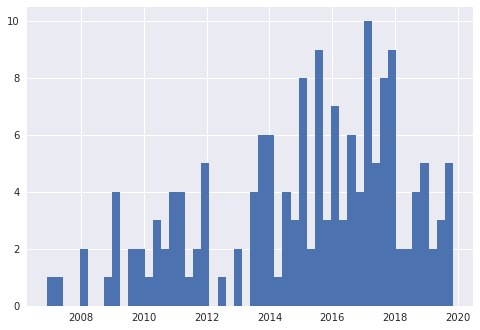

In [44]:
Client[Client['Active']=='Terminated']['Termination Date'].hist(bins = 50)

In [69]:
Client[Client['Active']=='Terminated'][['Current Eligibles','Eligibles at time of Launch']].describe()

,Current Eligibles,Eligibles at time of Launch
count,148.000000,160.000000
mean,7746.831081,8456.062500
std,37196.933942,36881.705583
min,0.000000,0.000000
25%,604.750000,700.500000
50%,1288.500000,1795.000000
75%,3392.750000,4304.750000
max,433512.000000,433512.000000


In [58]:
Client['Tenure'] = (Client['Termination Date']-Client['Launch Date'])/np.timedelta64(1, 'M')

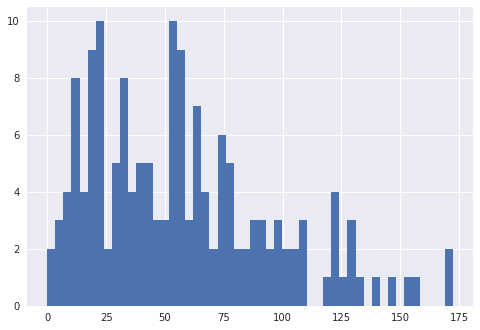

In [62]:
Client[(Client['Active']=='Terminated')]['Tenure'].hist(bins = 50)

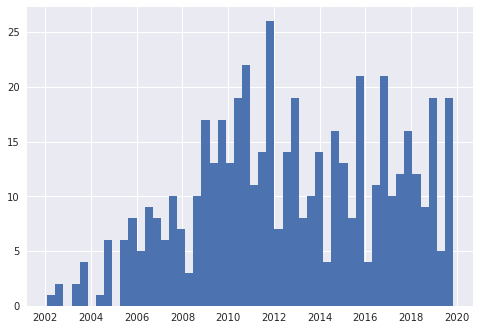

In [65]:
Client['Launch Date'].hist(bins = 50)

In [78]:
Perf['2os_loss'] = 0
Perf.loc[Perf['Default_Status']=='Chargeoff','2os_loss'] = Perf.loc[Perf['Default_Status']=='Chargeoff','Losses']
Perf.loc[Perf['Default_Status']=='151+','2os_loss'] = Perf.loc[Perf['Default_Status']=='151+','Current_Balance']

In [79]:
df = Perf[Perf['Year']>=2015]

In [13]:
def risk_analysis(df, values_level, index_list, file_name):
    """
    values_level := ['Unique_Order_ID','Unique_Customer_ID','2os_loss']

    """

    if values_level == 'Unique_Order_ID':
        dfs = df.pivot_table(values='Unique_Order_ID', index=index_list,
                             columns='YQ', aggfunc='nunique').reset_index().rename_axis(None, axis=1)
#         new_names = [(i,i+'_unit') for i in df.iloc[:, 2:].columns.values]
#         dfs.rename(columns = dict(new_names), inplace=True)
    elif values_level == 'Unique_Customer_ID':
        dfs = df.pivot_table(values='Unique_Customer_ID', index=index_list,
                             columns='YQ', aggfunc='nunique').reset_index().rename_axis(None, axis=1)
#         new_names = [(i,i+'_customer') for i in df.iloc[:, 2:].columns.values]
#         dfs.rename(columns = dict(new_names), inplace=True)
    elif values_level == '2os_loss':
        dfs = df[df['Bad']==1]
        dfs = dfs.loc[dfs.groupby('Unique_Order_ID')['Year_and_Month'].idxmin()].pivot_table(values='2os_loss', index=index_list, columns='YQ',
                             aggfunc='sum').reset_index().rename_axis(None, axis=1)
#         new_names = [(i,str(i)+'_loss') for i in df.iloc[:, 2:].columns.values]
#         dfs.rename(columns = dict(new_names), inplace=True)
    elif values_level == 'all':
        unit = df.pivot_table(values='Unique_Order_ID', index=index_list,
                             columns='YQ', aggfunc='nunique').reset_index().rename_axis(None, axis=1)
        new_names = [(i,str(i)+'_unit') for i in unit.iloc[:, 2:].columns.values]
        unit.rename(columns = dict(new_names), inplace=True)
        
        cust = df.pivot_table(values='Unique_Customer_ID', index=index_list,
                             columns='YQ', aggfunc='nunique').reset_index().rename_axis(None, axis=1)
        new_names = [(i,str(i)+'_customer') for i in cust.iloc[:, 2:].columns.values]
        cust.rename(columns = dict(new_names), inplace=True)
        
        loss = df.pivot_table(values='2os_loss', index=index_list, columns='YQ',
                             aggfunc='sum').reset_index().rename_axis(None, axis=1)
        new_names = [(i,str(i)+'_loss') for i in loss.iloc[:, 2:].columns.values]
        loss.rename(columns = dict(new_names), inplace=True)
        
        dfs = reduce(lambda x,y: pd.merge(x,y, how='left',on=index_list),[unit,cust,loss])
        
    else:
        print('Not valid values_level')
    dfs.to_csv('../data/{}.csv'.format(file_name))
    return dfs

In [91]:
def risk_ind(df):
    total_vol = df.pivot_table(values='Order_Amount', index='Year_and_Month', columns=[
        'Industry'], aggfunc='sum').reset_index().rename_axis(None, axis=1)
    new_order_vol = df[df['Payment_Order'] == 1].pivot_table(values='Order_Amount', index='Year_and_Month', columns=[
                                                             'Industry'], aggfunc='sum').reset_index().rename_axis(None, axis=1)
    avg_new_order_vol = df[df['Payment_Order'] == 1].pivot_table(values='Order_Amount', index='Year_and_Month', columns=[
        'Industry'], aggfunc='mean').reset_index().rename_axis(None, axis=1)
    new_bad_order_vol = df[(df['Bad'] == 1) & (df['Ever_Bad'] <= 1)].pivot_table(values='Order_Amount', index='Year_and_Month',
                                                                           columns=['Industry'], aggfunc='sum').reset_index().rename_axis(None, axis=1)
    bad_loss = df[df['Bad'] == 1].pivot_table(values='2os_loss', index='Year_and_Month',
                                                                           columns=['Industry'], aggfunc='sum').reset_index().rename_axis(None, axis=1)
    new_bad_loss = df[(df['Bad'] == 1) & (df['Ever_Bad'] <= 1)].pivot_table(values='2os_loss', index='Year_and_Month', columns=[
        'Industry'], aggfunc='sum').reset_index().rename_axis(None, axis=1)
    new_bad_unit = df[(df['Bad'] == 1) & (df['Ever_Bad'] <= 1)].pivot_table(values='Unique_Order_ID', index='Year_and_Month',
                                                                            columns=['Industry'], aggfunc='count').reset_index().rename_axis(None, axis=1)
#     good_unit = df[~((df['Bad'] == 1) & (df['Ever_Bad'] <= 1))].pivot_table(values='Unique_Order_ID', index='Year_and_Month',
#                                                                 columns=[Industry], aggfunc='count').reset_index().rename_axis(None, axis=1)
    final = reduce(lambda x,y: pd.merge(x,y, how='left',on='Year_and_Month'),[total_vol,new_order_vol,avg_new_order_vol,new_bad_order_vol,bad_loss,new_bad_loss,new_bad_unit])
    final.to_csv('../data/Industry.csv',index = False)
    
    
    
    return final

In [92]:
Industry = risk_ind(df)

In [82]:
reduce(lambda x,y: pd.merge(x,y, how='left',on='month_order'),Q1_vintage_list)

array(['Federal Government/Associations', 'Information',
       'Health Care and Social Assistance', nan,
       'Real Estate and Rental and Leasing',
       'Local Government/Associations', 'Administrative and Support',
       'State Government/Associations', 'Retail Trade', 'Wholesale Trade',
       'Nursing and Residential Care Facilities',
       'Other Services (except Public Administration)', 'Manufacturing',
       'Accommodation and Food Services', 'Educational Services',
       'Finance and Insurance',
       'Professional, Scientific, and Technical Services',
       'Transportation and Warehousing', 'Utilities',
       'Management of Companies and Enterprises',
       'Mining, Quarrying, and Oil and Gas Extraction', 'Engineering',
       'Arts, Entertainment, and Recreation', 'Construction', 'Machinery',
       'Healthcare', 'Retail & Wholesale Trade'], dtype=object)

In [63]:
df[df['Payment_Order']==1].pivot_table(values = 'Order_Amount', index='Year_and_Month',columns =  ['Affiliate/Fed Gov?'],aggfunc='mean')

Affiliate/Fed Gov?,Affiliate,Fed Gov
Year_and_Month,,
2015-01-01,921.463679,1288.379006
2015-02-01,925.180259,1305.894463
2015-03-01,964.436718,1331.947662
2015-04-01,924.909514,1325.443315
2015-05-01,911.167430,1291.791793
2015-06-01,892.800367,1269.140349
2015-07-01,920.343309,1335.052441
2015-08-01,882.241375,1318.302449
2015-09-01,872.233132,1325.082173


In [80]:
df.pivot_table(values = 'Order_Amount', index='Year_and_Month',columns =  ['Affiliate/Fed Gov?'],aggfunc='sum',fill_value=0,margins = True).reset_index().rename_axis(None, axis=1)

,Year_and_Month,Affiliate,Fed Gov,All
0,2015-01-01 00:00:00,2.289792e+08,9.003275e+07,3.190119e+08
1,2015-02-01 00:00:00,2.226606e+08,8.783252e+07,3.104932e+08
2,2015-03-01 00:00:00,2.250803e+08,8.878398e+07,3.138643e+08
3,2015-04-01 00:00:00,2.272744e+08,8.897678e+07,3.162512e+08
4,2015-05-01 00:00:00,2.286630e+08,8.905969e+07,3.177227e+08
5,2015-06-01 00:00:00,2.309536e+08,8.974990e+07,3.207035e+08
6,2015-07-01 00:00:00,2.357645e+08,9.097987e+07,3.267443e+08
7,2015-08-01 00:00:00,2.418551e+08,9.071331e+07,3.325684e+08
8,2015-09-01 00:00:00,2.444420e+08,8.990837e+07,3.343504e+08
9,2015-10-01 00:00:00,2.473568e+08,8.877166e+07,3.361285e+08


In [65]:
df[(df['Bad']==1)&(df['Ever_Bad']<=1)].pivot_table(values = 'Order_Amount', index='Year_and_Month',columns =  ['Affiliate/Fed Gov?'],aggfunc='sum')

Affiliate/Fed Gov?,Affiliate,Fed Gov
Year_and_Month,,
2015-01-01,2297003.53,906993.66
2015-02-01,2007807.63,834130.85
2015-03-01,2262940.17,815640.26
2015-04-01,2059967.66,710239.25
2015-05-01,2034883.75,700415.34
2015-06-01,1996430.96,658587.57
2015-07-01,2271069.45,925096.54
2015-08-01,2422551.26,897737.25
2015-09-01,2551205.75,940006.94


In [53]:
df[(df['Bad']==1)&(df['Ever_Bad']<=1)].pivot_table(values = '2os_loss', index='Year_and_Month',columns =  ['Affiliate/Fed Gov?'],aggfunc='sum',fill_value=0,margins = True)

Affiliate/Fed Gov?,Affiliate,Fed Gov,All
Year_and_Month,,,
2015-01-01 00:00:00,1.106863e+06,419154.65,1.526018e+06
2015-02-01 00:00:00,9.485869e+05,360288.08,1.308875e+06
2015-03-01 00:00:00,1.126374e+06,395317.89,1.521692e+06
2015-04-01 00:00:00,9.639355e+05,341698.42,1.305634e+06
2015-05-01 00:00:00,1.020920e+06,329663.63,1.350584e+06
2015-06-01 00:00:00,1.211193e+06,369868.58,1.581062e+06
2015-07-01 00:00:00,1.384223e+06,572316.34,1.956540e+06
2015-08-01 00:00:00,1.424598e+06,558113.04,1.982711e+06
2015-09-01 00:00:00,1.453224e+06,545478.59,1.998702e+06


In [54]:
df[(df['Bad']==1)&(df['Ever_Bad']<=1)].pivot_table(values = 'Unique_Order_ID', index='Year_and_Month',columns =  ['Affiliate/Fed Gov?'],aggfunc='count',fill_value=0,margins = True)

Affiliate/Fed Gov?,Affiliate,Fed Gov,All
Year_and_Month,,,
2015-01-01 00:00:00,2267,647,2914
2015-02-01 00:00:00,2017,565,2582
2015-03-01 00:00:00,2263,561,2824
2015-04-01 00:00:00,2064,502,2566
2015-05-01 00:00:00,1989,482,2471
2015-06-01 00:00:00,2042,468,2510
2015-07-01 00:00:00,2292,650,2942
2015-08-01 00:00:00,2525,602,3127
2015-09-01 00:00:00,2668,629,3297


In [55]:
df[~((df['Bad']==1)&(df['Ever_Bad']<=1))].pivot_table(values = 'Unique_Order_ID', index='Year_and_Month',columns =  ['Affiliate/Fed Gov?'],aggfunc='count',fill_value=0,margins = True)

Affiliate/Fed Gov?,Affiliate,Fed Gov,All
Year_and_Month,,,
2015-01-01 00:00:00,227267,65852,293119
2015-02-01 00:00:00,222222,64342,286564
2015-03-01 00:00:00,225172,65081,290253
2015-04-01 00:00:00,228912,65257,294169
2015-05-01 00:00:00,231857,65428,297285
2015-06-01 00:00:00,236047,66156,302203
2015-07-01 00:00:00,242351,66880,309231
2015-08-01 00:00:00,250723,66729,317452
2015-09-01 00:00:00,255645,66189,321834


In [17]:
loss = risk_analysis(df, '2os_loss', ['Affiliate/Fed Gov?','Bad'], 'loss')

In [16]:
Channel = risk_analysis(df, 'all', ['Affiliate/Fed Gov?','Bad'], 'Channel')

In [17]:
Channel

,Affiliate/Fed Gov?,Bad,2015Q1_unit,2015Q2_unit,2015Q3_unit,2015Q4_unit,2016Q1_unit,2016Q2_unit,2016Q3_unit,2016Q4_unit,2017Q1_unit,2017Q2_unit,2017Q3_unit,2017Q4_unit,2018Q1_unit,2018Q2_unit,2018Q3_unit,2018Q4_unit,2019Q1_unit,2019Q2_unit,2019Q3_unit,2019Q4_unit,2015Q1_customer,2015Q2_customer,2015Q3_customer,2015Q4_customer,2016Q1_customer,2016Q2_customer,2016Q3_customer,2016Q4_customer,2017Q1_customer,2017Q2_customer,2017Q3_customer,2017Q4_customer,2018Q1_customer,2018Q2_customer,2018Q3_customer,2018Q4_customer,2019Q1_customer,2019Q2_customer,2019Q3_customer,2019Q4_customer,2015Q1_loss,2015Q2_loss,2015Q3_loss,2015Q4_loss,2016Q1_loss,2016Q2_loss,2016Q3_loss,2016Q4_loss,2017Q1_loss,2017Q2_loss,2017Q3_loss,2017Q4_loss,2018Q1_loss,2018Q2_loss,2018Q3_loss,2018Q4_loss,2019Q1_loss,2019Q2_loss,2019Q3_loss,2019Q4_loss
0,Affiliate,0,246025,254724,277279,367728,348884,367210,387878,478983,433480,447084,470240,584637,545943,578160,604724,742929,680252,684881,683569,600150,120132,120188,125947,148603,146253,147909,152854,173614,167774,168792,175430,199248,195254,197066,200687,221409,212343,209653,210991,197777,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000e+00,0.00,0.00,0.00,0.00,0.000000e+00,0.00
1,Affiliate,1,12530,12287,13105,15579,17636,20018,19480,23993,26155,25104,31779,36844,39016,39916,41969,51063,53592,53742,50577,44967,7141,6932,7056,8013,8710,9685,9156,10801,11490,10965,13618,15692,16602,16312,17476,21155,19768,18925,16820,14918,12064679.09,12156401.84,14314249.30,15555420.19,17308923.72,17965190.35,17045425.25,21211628.25,22191754.65,21782472.35,28909334.78,31872666.70,34854841.95,3.748968e+07,38190538.48,42862713.92,47178044.38,41329522.31,4.247098e+07,16922331.32
2,Fed Gov,0,71582,72148,74318,88102,81381,82682,84581,99855,86447,87802,89270,107235,93169,92260,91345,107311,92275,92556,89635,75730,32856,32405,32591,35335,34229,34041,34473,37424,35233,35028,35380,38408,36416,35792,35449,38610,35702,35525,34829,31478,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000e+00,0.00,0.00,0.00,0.00,0.000000e+00,0.00
3,Fed Gov,1,4212,4001,4110,4758,5273,5925,5530,6252,6029,5570,5891,6606,6725,7140,7451,8735,8607,8254,7677,7258,1988,1915,1950,2304,2517,2817,2576,2782,2612,2474,2657,2825,2773,2971,3145,3713,3218,3158,3066,2883,6068310.63,5710685.95,6844512.44,7548844.68,8364342.84,8306066.64,8019068.63,8622486.83,8079751.94,7256395.36,8119155.57,8868684.19,9112999.80,9.557924e+06,10814490.88,12373093.18,12662654.32,11351341.64,1.224927e+07,4788179.79


In [100]:
Perf.pivot_table(
    values='Order_Amount', index='Affiliate/Fed Gov?', columns='YQ', aggfunc='sum').to_csv('../data/Total_bal_by_YQ.csv')

In [17]:
Channel_DQ_unit = unit_analysis(Perf, ['Affiliate/Fed Gov?','Delinquency_Bucket'], 'Channel_DQ_unit')
Channel_CO_unit = unit_analysis(Perf, ['Affiliate/Fed Gov?','Default_Status'], 'Channel_CO_unit')

In [18]:
Industry_DQ = unit_analysis(Perf, ['Industry','Delinquency_Bucket'], 'Industry_DQ')
Industry_CO = unit_analysis(Perf, ['Industry','Default_Status'], 'Industry_CO')

In [19]:
Company_DQ = unit_analysis(Perf, ['Account Name','Delinquency_Bucket'], 'Company_DQ')
Company_CO = unit_analysis(Perf, ['Account Name','Default_Status'], 'Company_CO')

In [20]:
def dollar_analysis(df, index_list,balance_ind, file_name):
    dfs = df.pivot_table(values=balance_ind,index = index_list,columns ='YQ',aggfunc='sum')
    dfs.to_csv('./data/{}.csv'.format(file_name))
    return dfs

In [13]:
Channel_DQ_Dollar = dollar_analysis(Perf,['Affiliate/Fed Gov?','Delinquency_Bucket'],'Current_Balance','Channel_DQ_Dollar')
Channel_CO_Dollar = dollar_analysis(Perf,['Affiliate/Fed Gov?','Default_Status'],'Losses','Channel_CO_Dollar')

In [21]:
Industry_DQ_Dollar = dollar_analysis(Perf, ['Industry','Delinquency_Bucket'],'Current_Balance', 'Industry_DQ_Dollar')
Industry_CO_Dollar = dollar_analysis(Perf, ['Industry','Default_Status'],'Losses', 'Industry_CO_Dollar')

In [22]:
Company_DQ_Dollar = dollar_analysis(Perf, ['Account Name','Delinquency_Bucket'], 'Current_Balance','Company_DQ_Dollar')
Company_CO_Dollar = dollar_analysis(Perf, ['Account Name','Default_Status'],'Losses', 'Company_CO_Dollar')